# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for (0, 'W')
Gradients are different at (0, 0). Analytic: 0.00002, Numeric: 0.00001


False

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for (0, 'W')
Gradients are different at (0, 1). Analytic: -0.00123, Numeric: -0.00118


False

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.01)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 0.01)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 1.985179, Train accuracy: 0.359778, val accuracy: 0.361000
Loss: 2.369761, Train accuracy: 0.557444, val accuracy: 0.545000
Loss: 2.721862, Train accuracy: 0.569444, val accuracy: 0.557000
Loss: 3.548311, Train accuracy: 0.654667, val accuracy: 0.636000
Loss: 3.615570, Train accuracy: 0.685000, val accuracy: 0.645000
Loss: 3.569147, Train accuracy: 0.724222, val accuracy: 0.671000
Loss: 4.004584, Train accuracy: 0.719444, val accuracy: 0.678000
Loss: 4.133325, Train accuracy: 0.725667, val accuracy: 0.661000
Loss: 4.849701, Train accuracy: 0.720000, val accuracy: 0.647000
Loss: 5.094152, Train accuracy: 0.733000, val accuracy: 0.667000
Loss: 5.715943, Train accuracy: 0.749444, val accuracy: 0.706000
Loss: 5.619437, Train accuracy: 0.753556, val accuracy: 0.684000
Loss: 5.678403, Train accuracy: 0.784444, val accuracy: 0.704000
Loss: 6.041727, Train accuracy: 0.766667, val accuracy: 0.680000
Loss: 6.405663, Train accuracy: 0.746111, val accuracy: 0.679000
Loss: 6.357599, Train acc

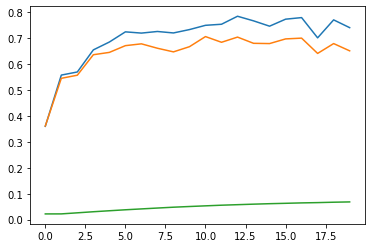

In [10]:
plt.plot(train_history)
plt.plot(val_history)
plt.plot([i/100 for i in loss_history])

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 1.906977, Train accuracy: 0.362556, val accuracy: 0.375000
Loss: 1.673692, Train accuracy: 0.576444, val accuracy: 0.574000
Loss: 2.181144, Train accuracy: 0.582667, val accuracy: 0.548000
Loss: 0.773368, Train accuracy: 0.659778, val accuracy: 0.624000
Loss: 1.107633, Train accuracy: 0.690000, val accuracy: 0.644000
Loss: 2.128651, Train accuracy: 0.695889, val accuracy: 0.662000
Loss: 0.668363, Train accuracy: 0.756000, val accuracy: 0.699000
Loss: 1.044617, Train accuracy: 0.753222, val accuracy: 0.682000
Loss: 1.248500, Train accuracy: 0.756778, val accuracy: 0.690000
Loss: 0.511209, Train accuracy: 0.786778, val accuracy: 0.717000
Loss: 0.445406, Train accuracy: 0.775778, val accuracy: 0.690000
Loss: 0.570236, Train accuracy: 0.797889, val accuracy: 0.717000
Loss: 0.827501, Train accuracy: 0.798778, val accuracy: 0.700000
Loss: 0.403548, Train accuracy: 0.814222, val accuracy: 0.708000
Loss: 0.860911, Train accuracy: 0.783000, val accuracy: 0.688000
Loss: 0.654519, Train acc

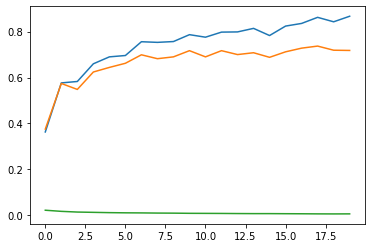

In [12]:
plt.plot(train_history)
plt.plot(val_history)
plt.plot([i/100 for i in loss_history])

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [13]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.258453, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.193012, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.359960, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.013943, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.188985, Train accuracy: 0.204889, val accuracy: 0.212000
Loss: 2.567811, Train accuracy: 0.256667, val accuracy: 0.257000
Loss: 2.310323, Train accuracy: 0.277778, val accuracy: 0.280000
Loss: 2.762512, Train accuracy: 0.307444, val accuracy: 0.311000
Loss: 2.996860, Train accuracy: 0.352667, val accuracy: 0.351000
Loss: 3.422384, Train accuracy: 0.393667, val accuracy: 0.390000
Loss: 3.660026, Train accuracy: 0.430778, val accuracy: 0.429000
Loss: 4.075965, Train accuracy: 0.465111, val accuracy: 0.449000
Loss: 4.114870, Train accuracy: 0.493000, val accuracy: 0.483000
Loss: 4.729312, Train accuracy: 0.524889, val accuracy: 0.524000
Loss: 5.280815, Train accuracy: 0.549778, val accuracy: 0.547000
Loss: 5.491349, Train acc

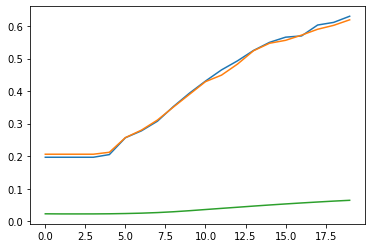

In [14]:
plt.plot(train_history)
plt.plot(val_history)
plt.plot([i/100 for i in loss_history])

Loss: 2.283436, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.158945, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.158044, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.027027, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.023302, Train accuracy: 0.218667, val accuracy: 0.229000
Loss: 1.788006, Train accuracy: 0.260000, val accuracy: 0.261000
Loss: 1.949132, Train accuracy: 0.287000, val accuracy: 0.290000
Loss: 1.393011, Train accuracy: 0.340222, val accuracy: 0.337000
Loss: 1.716561, Train accuracy: 0.402111, val accuracy: 0.393000
Loss: 1.812216, Train accuracy: 0.448889, val accuracy: 0.432000
Loss: 1.714024, Train accuracy: 0.481778, val accuracy: 0.481000
Loss: 1.403880, Train accuracy: 0.522111, val accuracy: 0.515000
Loss: 1.491901, Train accuracy: 0.554222, val accuracy: 0.554000
Loss: 1.324721, Train accuracy: 0.591222, val accuracy: 0.586000
Loss: 1.388699, Train accuracy: 0.610111, val accuracy: 0.588000
Loss: 1.330535, Train acc

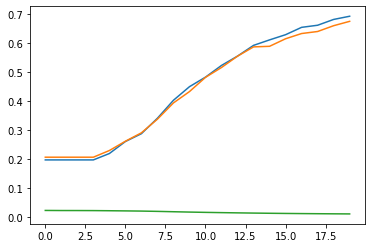

In [15]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
plt.plot(val_history)
plt.plot([i/100 for i in loss_history])

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [16]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.308775, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.301469, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.284900, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.284201, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.296964, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.274332, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.249938, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.268191, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.303653, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.239989, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.254519, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.198031, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.155267, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.177020, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.163194, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.152747, Train acc

Loss: 0.084197, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.049357, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.036001, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.095927, Train accuracy: 1.000000, val accuracy: 0.066667
Loss: 0.070101, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.033661, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.061697, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.075557, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.029033, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.017244, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.058827, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.048383, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.021510, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.058999, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.022210, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 0.035695, Train acc

In [17]:
data_size = 15
model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=100, reg=1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=1000, batch_size=5)

# You should expect this to reach 1.0 training accuracy
loss_history, train_history, val_history = trainer.fit()

Loss: 2.332987, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.362128, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.551714, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 5.949216, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 3.963839, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 6.334563, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 33.250267, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 115.200660, Train accuracy: 0.066667, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.000000, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.000000, val accuracy: 0.266667
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.2000

/home/marie/DL_/assignment2/layers.py:60: RuntimeWarning: divide by zero encountered in log
  return np.mean(-np.log(probs[rows, cols]))


Loss: inf, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.133333, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.133333, val

Loss: inf, Train accuracy: 0.133333, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.133333, val accuracy: 0.266667
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: inf, Train accuracy: 0.066667, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.266667, val accuracy: 0.333333
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.266667
Loss: inf, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: inf, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: inf, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 4040936628858451025163914973784903415692411236688330188983321478605832192.000000, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 3579632924228517389200643038574917893197559874863080783240099425977106432.000000, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 3170990552217752005723222756703167594809406692403350119732994390544613376.000000, Train accuracy: 0.400000, val accuracy: 0.200000
Loss: 2808997820473823303788703946368605911304439

Loss: 40973528503468326889149514930293922914606025709736905349490599207013749620736.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 36296088041911346376554494526102311103081640913193549255396394675732731658240.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 32152613047096108536755750266562056980901740266655492737177356627686673350656.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 28482147292638522484104224803872438146746418721259962552356126593625083609088.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 25230693169830040546002741565599370260171883432293982049428193913226825564160.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 22350417308411306907298220664583647832357054876655296744628743897284729634816.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 19798946881787026839491282185489333947719197327268915501189267807693531250688.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 1753874

Loss: 9552096521603880057183918528685319137572509697696258642677776356023992320.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 8461651924940313399856216160105298637172112196710530775968651907927375872.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 7495689887231574680020973505431986922113731511579702787000644481079836672.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 6639999775923426404371270805098524296771631194727838347754181171452313600.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 5881993210440434284402533761015072346153153070552697746335133455861415936.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 5210518869762437178803814093977325678596553419307895662205517224994668544.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 4615698441127157277615512520851124089431464635264083132375886857660006400.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 40887812964383339066578469707329668

Loss: 1972652072481463802164277703497609533713838512768508291258930557878272.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 1747458808503283287531160128474336078850670137573392997370972711419904.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1547973071386317454960480857284508536639019405305529126768374330687488.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1371260151070214323633939308446309381242976695096962171065018668285952.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1214720357007966633847686271454504745802502996511983350119433414639616.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1076050773135905178758032689722813977515087043901371939230759363018752.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 953211378805258330810023879867900608324160952491986402249536866091008.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 844395037267506186858198938460165630652519222353132321837

Loss: 519145836822050083912183045707001819699958524216929754404190420992.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 459881384106078659892338910892537779532954143118421751781010702336.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 407382420211560210454252691630727607408031049774735321938771574784.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 360876613042347028176510331920134708689323062514327370286208385024.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 319679798095569143628996344994920104810475501130520143416774361088.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 283185913459101770963872113464725565659031045495547289017616695296.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 250858083805757298357157431379096453675058996103466584356555849728.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 222220722217472929717537094961450836529958134813672083259830304768.000000, Train acc

Loss: 94972445410358523352626424752962921465496395741690449667031040.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 84130617158788278925478595657029371784819313625398831942205440.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 74526466207498695681282042756925141846511789065136093739876352.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 66018702262631089635495647444946943248217140764875880990244864.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 58482164393880659145787555092292480838674734025477784252448768.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 51805979744755102652402952756928717928814204964265647352578048.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 45891932440086006492462391790552735553400380044611115770970112.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 40653018695175629296361972561027361795956544377549873433542656.000000, Train accuracy: 0.200000, val accuracy: 0

Loss: 8395461813047151011744775732819955325442707194018588000256.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 7437055880922481857485759733291888961961778423577052184576.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 6588059288174984400713030866998472332577362904521042296832.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 5835982125110117175291493772200247605241670963818380918784.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 5169760300387292628840645910450293931091856804470239264768.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 4579592772991267225729647356780898160456197395434470113280.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 4056797365414153032772518428677569282375216977088547389440.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 3593683036861274980683506501149044983982358270246530318336.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 318343673744376118

Loss: 1067633513514688946610504784907347719503995953225924608.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 945755013502049471185004814449393520435724419969581056.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 837789872874719859974147917129459018336615416813584384.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 742149775651089867373933704878823210595404274873663488.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 657427724220444951505902640331925104522728735414157312.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 582377340469439932236104597416617590834247567035858944.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 515894529842693138151577569770219361039102229832794112.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 457001238590565144256744574254673999365146847769264128.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 4048310652508631557493566530112157805618456800159

Loss: 135768745610673216665616626392519634500846767570944.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 120269708858677435202345000805683893579981288112128.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 106540005241190979782512301969600536001559968874496.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 94377651900119680291463923581263204463167762595840.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 83603723859555807743642668101737657453349745721344.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 74059721792845316732070677864607651048518167035904.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 65605240279099569789741258442639757995919234039808.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 58115902245992349043437131505284638752836123885568.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 51481529211649344457723805178880657301181067952128.000000, Train accuracy: 0.20

Loss: 9418021634585663787120371345915785276366520320.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 8342882707810023150289867716100676320143343616.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 7390479081155526239972817909061085094005964800.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 6546799584976398347507930968517171101644619776.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 5799432531394938307752611318892010273264107520.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 5137383121271027724813094757820571949213941760.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 4550911695557254532591573100922100654956085248.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 4031390451494261992861275845741621596213215232.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 3571176515744073197303948129376301875594264576.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 3163

Loss: 356370570882567905003335512515551940313088.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 315688154980476899362701628095214508834816.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 279649946818468941741914311831949622116352.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 247725774698163596238829810700180875378688.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 219445990060000108364802772303229969498112.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 194394558305808102538656281469893843353600.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 172202938356622741291490044745045889777664.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 152544660905607324444065311776582045532160.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 135130525604714719329849646862273569882112.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 1197043465290841797039353174589829483069

Loss: 17184269435928168749027486940549611520.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 15222554150531076470670092195573268480.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 13484783611537614670050167647954272256.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 11945392819880325806972568799973212160.000000, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 10581735215918519810139937336371183616.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 9373749517341693580425134201886474240.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 8303664590064737209374352903550009344.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 7355738010359037816586783555558834176.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 6516024472108271801811481778962038784.000000, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 5772170632140481604060275238061998080.000000, Train accuracy: 0.200000, val accu

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [18]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=0.01, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.304508, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.307905, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.246736, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.235685, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.188492, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.311772, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.435931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.225049, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.100659, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.355682, Train accuracy: 0.533333, val accuracy: 0.066667
Loss: 1.822286, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.009299, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.261461, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.466319, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 0.551693, Train accuracy: 0.600000, val accuracy: 0.066667
Loss: 1.312026, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [19]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above

print('best validation accuracy achieved: %f' % best_val_accuracy)

TypeError: must be real number, not NoneType

Loss: 2.308022, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.184943, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320917, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221517, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.246963, Train accuracy: 0.222444, val accuracy: 0.225000
Loss: 1.770575, Train accuracy: 0.263000, val accuracy: 0.264000
Loss: 2.006900, Train accuracy: 0.297889, val accuracy: 0.311000
Loss: 1.780271, Train accuracy: 0.342778, val accuracy: 0.341000
Loss: 1.994106, Train accuracy: 0.402556, val accuracy: 0.395000
Loss: 1.701707, Train accuracy: 0.439111, val accuracy: 0.439000
Loss: 1.808624, Train accuracy: 0.489222, val accuracy: 0.490000
Loss: 1.357587, Train accuracy: 0.530778, val accuracy: 0.527000
Loss: 1.440596, Train accuracy: 0.562889, val accuracy: 0.559000
Loss: 1.216439, Train accuracy: 0.587889, val accuracy: 0.578000
Loss: 1.130406, Train accuracy: 0.610667, val accuracy: 0.592000
Loss: 0.977987, Train acc

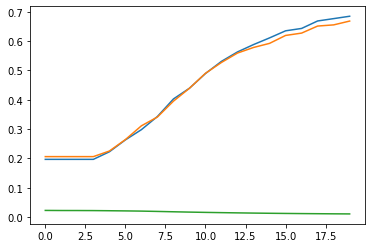

In [20]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

plt.plot(train_history)
plt.plot(val_history)
plt.plot([i/100 for i in loss_history])

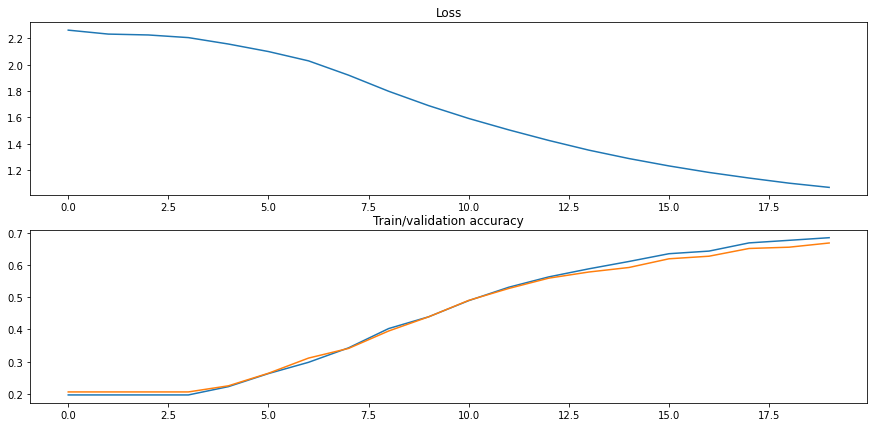

In [21]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [22]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.626000
